# Sentiment analysis on Tweets
The project will create a model that will be able to predict whether the sentiment of a tweet is positive or genative

## Load the data

In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
# Label the columns of our dataset
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
# Drop the columns that we won't need
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
# For this example, we are only keeping 3% of the data but ideally
# we will train with the whole dataset if we had the computation power
df = df.sample(frac=0.03)

# Dictionary to replace the numbers to a Binary classification
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]

# We replace the sentiment values with our binary classification
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

# Print the final data
print(df.head())

        sentiment                                               text
529902   Negative                              That is sad for evan 
1395040  Positive  @bowwow614 good morning darling  ...back to Mi...
644426   Negative                I feel extremely awkward right now 
914042   Positive  @Ms_Mary_Typhoid Are you coming to the wedding...
1117053  Positive  http://twitpic.com/69rbz - Angie &amp; @justin...


## Plot the data 
We plot the data just to make sure everything was correct with our sampling

Text(0.5, 1.0, 'Sentiment Data Distribution')

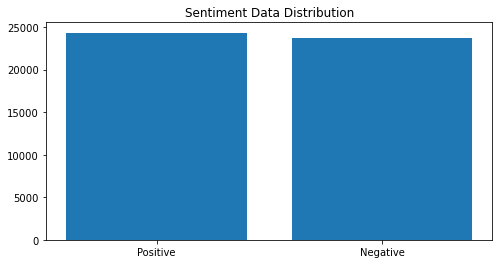

In [8]:
import matplotlib.pyplot as plt
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

## Preprocessing of the data
We process the data to get rid of noisy values + tokenize the words on the tweets correctly

In [9]:
import nltk
from nltk.corpus import stopwords
import re
import pickle
from nltk.tokenize import TweetTokenizer

# We load stop words from nltk corpus
stop_words = stopwords.words('english')
# We created a regex that will help us clean all of the links that are
# attached in our data
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# For this example, we found a TweetTokenizer which suppose to do a better job
# at tokenize the words on a Tweet
tknzr = TweetTokenizer()
all_words = []

# We define a function that will help us preprocess every row in our data
def preprocess(text, stem=False):
    # We get rid of the links on the tweets + lowercase + blank spaces at the end and beginning
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    # we split into words our tweet
    words = tknzr.tokenize(text)
    for token in words:
        # we get rid of stop_words in our tweet as it wont add any value to our training
        if token not in stop_words:
            # append the token to our all_words array that will help us track the most used words
            all_words.append(token)
            tokens.append(token)
            # return the new tokenized string without stop_words for our data
    return " ".join(tokens)

# we aplly the function that we just create for every row
df.text = df.text.apply(lambda x: preprocess(x))

# we transform the dataframe into a list of tuples with the text and sentiment
documents = []
for index, row in df.iterrows():
    documents.append((row['text'], row['sentiment']))

# save the pickle so we don't have to process again the data
save_doc = open("pickle/tweets.pickle", "wb")
pickle.dump(documents, save_doc)
save_doc.close()

# we sort by most frequent words and we select the top 5000 words used
all_words = nltk.FreqDist(all_words)
word_features = list(all_words.keys())[:5000]

# save the pickle again so we don't have to process
save_word = open("pickle/word_tweets.pickle", "wb")
pickle.dump(word_features, save_word)
save_word.close()

###  If the preprocessing was done we just load the pickle

In [10]:
import pickle

save_doc = open("pickle/tweets.pickle", "rb")
documents = pickle.load(save_doc)
save_doc.close()

save_word = open("pickle/word_tweets.pickle", "rb")
word_features = pickle.load(save_word)
save_word.close()

## Generating the training and testing dataset
Before we separate the data, we need and extra step which is to create a dictionary for every tweet that will contain which of the most used words was used in that tweet and we will train with that dictionary

In [11]:
# Create the dictionary for every tweet with the most used words and marking
# True for the ones that are actually in our tweet
def find_features(document):
    words = document.split()
    features = {}
    for w in word_features:
        features[w] = (w in words)
    
    return features

featuresets = [(find_features(rev), category) for (rev, category) in documents]

# Divide our dataset into a 90/10 ratio for training and testing
training_size = int(len(featuresets)*.9)
training_set = featuresets[:training_size]
testing_set = featuresets[training_size:]

# Save the pickle with the featureset
save_featureset = open("pickle/featureset.pickle", "wb")
pickle.dump(featuresets, save_featureset)
save_featureset.close()

### If we already generated the feature set
We just need to load the pickle and separate the training and testing data

In [4]:
save_featureset = open("pickle/featureset.pickle", "rb")
documents = pickle.load(save_featureset)
save_featureset.close()

# Divide our dataset into a 90/10 ratio for training and testing
training_size = int(len(featuresets)*.9)
training_set = featuresets[:training_size]
testing_set = featuresets[training_size:]

MemoryError: 

## Train the models
We generate correctly all of our data for training so we are ready to train the models

In [12]:
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

classifier = nltk.NaiveBayesClassifier.train(training_set)
print('Naive Bayes Algo accuracy percent:', (nltk.classify.accuracy(classifier, testing_set)*100))
classifier.show_most_informative_features(15)
save_class = open("pickle/naive.pickle", "wb")
pickle.dump(classifier, save_class)
save_class.close()

Naive Bayes Algo accuracy percent: 73.20833333333333
Most Informative Features
                   sadly = True           Negati : Positi =     27.0 : 1.0
                 hurting = True           Negati : Positi =     23.7 : 1.0
                    knee = True           Negati : Positi =     20.3 : 1.0
                headache = True           Negati : Positi =     16.5 : 1.0
                 welcome = True           Positi : Negati =     15.8 : 1.0
                   awful = True           Negati : Positi =     15.4 : 1.0
                   hurts = True           Negati : Positi =     15.3 : 1.0
                     sad = True           Negati : Positi =     14.1 : 1.0
              frustrated = True           Negati : Positi =     14.1 : 1.0
                    grrr = True           Negati : Positi =     14.1 : 1.0
               miserable = True           Negati : Positi =     14.1 : 1.0
               depressed = True           Negati : Positi =     13.8 : 1.0
            disappoin

In [ ]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print('MNB classifier Algo accuracy percent:', (nltk.classify.accuracy(MNB_classifier, testing_set)*100))
save_class = open("pickle/mnb.pickle", "wb")
pickle.dump(MNB_classifier, save_class)
save_class.close()

In [6]:
BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print('BernoulliNB classifier Algo accuracy percent:', (nltk.classify.accuracy(BernoulliNB_classifier, testing_set)*100))
save_class = open("pickle/bernoulli.pickle", "wb")
pickle.dump(BernoulliNB_classifier, save_class)
save_class.close()

144000


In [ ]:
SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)
print('SGDClassifier classifier Algo accuracy percent:', (nltk.classify.accuracy(SGDClassifier_classifier, testing_set)*100))
save_class = open("pickle/sgd.pickle", "wb")
pickle.dump(SGDClassifier_classifier, save_class)
save_class.close()

In [ ]:
LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print('LogisticRegression classifier Algo accuracy percent:', (nltk.classify.accuracy(LogisticRegression_classifier, testing_set)*100))
save_class = open("pickle/logistic.pickle", "wb")
pickle.dump(LogisticRegression_classifier, save_class)
save_class.close()

In [ ]:
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print('LinearSVC classifier Algo accuracy percent:', (nltk.classify.accuracy(LinearSVC_classifier, testing_set)*100))
save_class = open("pickle/linearsvc.pickle", "wb")
pickle.dump(LinearSVC_classifier, save_class)
save_class.close()

### If we already train all of our models
We just pickle the classifiers so we can move on to testing

In [ ]:
save_class = open("pickle/naive.pickle", "rb")
classifier = pickle.load(save_class)
save_class.close()
print('Naive Bayes Algo accuracy percent:', (nltk.classify.accuracy(classifier, testing_set)*100))
classifier.show_most_informative_features(15)

save_class = open("pickle/mnb.pickle", "rb")
MNB_classifier = pickle.load(save_class)
save_class.close()
print('MNB classifier Algo accuracy percent:', (nltk.classify.accuracy(MNB_classifier, testing_set)*100))

save_class = open("pickle/bernoulli.pickle", "rb")
BernoulliNB_classifier = pickle.load(save_class)
save_class.close()
print('BernoulliNB classifier Algo accuracy percent:', (nltk.classify.accuracy(BernoulliNB_classifier, testing_set)*100))

save_class = open("pickle/logistic.pickle", "rb")
LogisticRegression_classifier = pickle.load(save_class)
save_class.close()
print('LogisticRegression classifier Algo accuracy percent:', (nltk.classify.accuracy(LogisticRegression_classifier, testing_set)*100))

save_class = open("pickle/sgd.pickle", "rb")
SGDClassifier_classifier = pickle.load(save_class)
save_class.close()
print('SGDClassifier classifier Algo accuracy percent:', (nltk.classify.accuracy(SGDClassifier_classifier, testing_set)*100))

save_class = open("pickle/linearsvc.pickle", "rb")
LinearSVC_classifier = pickle.load(save_class)
save_class.close()
print('LinearSVC classifier Algo accuracy percent:', (nltk.classify.accuracy(LinearSVC_classifier, testing_set)*100))

## Create Vote Classifier
Once we have all of our models ready, we can create a Vote Classifier that will combine the prediction of each different classification model which will allow us to have a confidence on the prediction that we give for real life data.

In [ ]:
from nltk.classify import ClassifierI
from statistics import mode

class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)
    
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf
    
# We can add as many classifiers as we want to make it more robust
voted_classifier = VoteClassifier(
    classifier, 
    MNB_classifier, 
    BernoulliNB_classifier,
    LogisticRegression_classifier,
    SGDClassifier_classifier, 
    LinearSVC_classifier)

print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set)) * 100)
print("Classification:", voted_classifier.classify(testing_set[0][0]), "Confidence %: ", voted_classifier.confidence(testing_set[0][0])*100)

## We create a function that will call this Vote Classifier
It will receive the text and will return a tople with the classification and the confidence on the result

In [ ]:
def sentiment(text):
    feats = find_features(text)
    return voted_classifier.classify(feats), voted_classifier.confidence(feats)

## Evaluation on real time tweets
We made use of the twitter API to get real time tweets and output a result for each of them in real time as well

In [ ]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json

#consumer key, consumer secret, access token, access secret.
ckey="3MuY1EnZFbRhfA5utqmqtGRlE"
csecret="TXutBRikoAFG2b1EmZ29xE26O71i9vOM4uuWfnyvD84Y5UfbAz"
atoken="360796736-YqflPUUIK5Dy8QmOmVYJLJPEjuCtQnLK9NovGAL0"
asecret="dmzktdklo30OKGGcnvQkjSZZsgvzLhDijodQwwCVfhfXx"

class listener(StreamListener):

    def on_data(self, data):
        all_data = json.loads(data)
        
        tweet = all_data["text"]
        
        # we call our function to see the sentiment on that tweet
        sentiment_value, confidence = s.sentiment(tweet)

        # we print the results
        print(tweet, sentiment_value, confidence)
        
        # if we are confident on our prediction, we will save the result for plotting in the next function
        if confidence*100 >= 80:
            output = open("twitter.txt","a")
            output.write(sentiment_value)
            output.write('\n')
            output.close()
        return True

    def on_error(self, status):
        print(status)

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

twitterStream = Stream(auth, listener())
# we select a keyword for we will filter only the tweets related to that word
twitterStream.filter(track=["car"])

# Plot of the Twitter Analysis
If you want to see the plot in real time, run this script on a separate notebook

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import time

style.use("ggplot")

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    pullData = open("twitter.txt","r").read()
    lines = pullData.split('\n')

    xar = []
    yar = []

    x = 0
    y = 0

    for l in lines[-200:]:
        x += 1
        if "pos" in l:
            y += 1
        elif "neg" in l:
            y -= 1

        xar.append(x)
        yar.append(y)
        
    ax1.clear()
    ax1.plot(xar,yar)
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()